# ARPES Spectral Clustering - Methodology Pipeline
## A pipeline for data visualization of 2D mappings using PCA for data reduction and spectral clustering.
#### Authors: Marc Raventós (mraventos@cells.es), Joaquín Otón (joton@cells.es)


In [33]:
import os
import requests

import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn import decomposition
from sklearn.cluster import SpectralClustering

import plotly.graph_objects as go
from plotly.offline import plot

In [34]:
# Download example dataset if needed
# Define the file name and URL
filename = "011_Au_Mica.nxs"
url = "https://zenodo.org/records/14893727/files/011_Au_Mica.nxs?download=1"

# Check if the file already exists
if os.path.exists(filename):
    print(f"The file '{filename}' already exists. Skipping download.")
else:
    # Download the file
    print(f"Downloading '{filename}'...")
    response = requests.get(url, stream=True)
    with open(filename, "wb") as file:
        for chunk in response.iter_content(chunk_size=1024):
            file.write(chunk)
    print(f"Download completed: {filename}")

Download completed: 011_Au_Mica.nxs


In [35]:
# Location of the .nxs file to process
file_location = '011_Au_Mica.nxs'
contrast = 0.9 # (0,1] Contrast of the image. Lower values will make the ARPES image brighter
n_clusters = 6 # >1 Number of clusters used for Spectral clustering

In [36]:
working_directory = os.getcwd()
file_name = os.path.basename(file_location).rstrip(".nxs")
output_directory = os.path.join(working_directory,f'output_{file_name}') 
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

file = h5py.File(file_location)
data = file['entry1/data/data'][...]
steps_dimx = np.round(file['entry1/instrument/manipulator/sax'][...],2)
steps_dimz = np.round(file['entry1/instrument/manipulator/saz'][...],2)
xticks = np.arange(len(steps_dimz))[::3]  # Select every other tick
yticks = np.arange(len(steps_dimx))[::2]  # Select every other tick
realdimz, realdimx, arpesdimx, arpesdimy = data.shape

In [37]:
flattened_real = data.reshape(-1,arpesdimx,arpesdimy)
flattened_arpes =  data.reshape(realdimz,realdimx,-1)
flattened_all = flattened_arpes.reshape(realdimx*realdimz,-1)

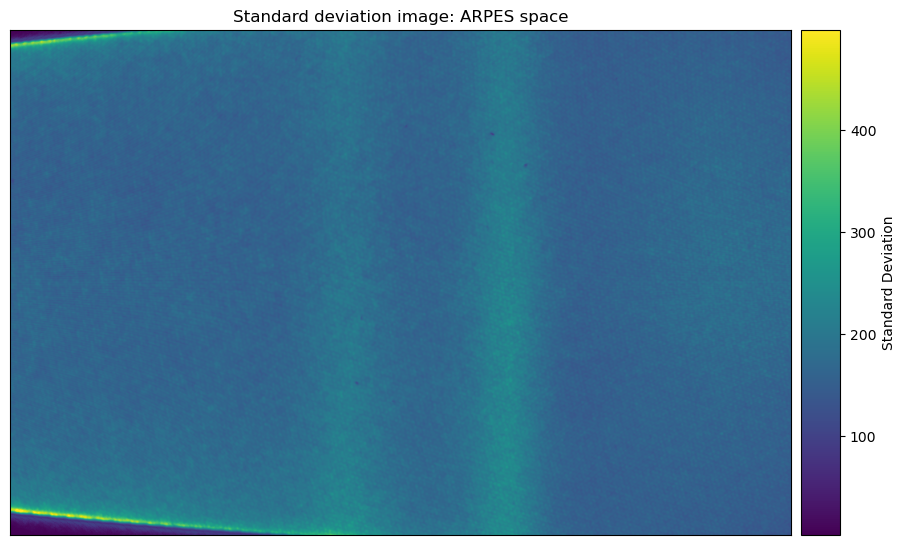

In [38]:
std_image = flattened_real.std(0)
fig, ax = plt.subplots(figsize=(9, 9))
im = ax.imshow(std_image,vmax=std_image.max()*contrast)
ax.set_title('Standard deviation image: ARPES space')
ax.set_xticks([]), ax.set_yticks([]) 
# Create a divider for the axis to align the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# Add colorbar to the aligned axis
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_ylabel('Standard Deviation')

plt.tight_layout(pad=0.5)
plt.savefig(os.path.join(output_directory,'std_deviation_arpes_space.png'),dpi=600, bbox_inches='tight')
plt.show()


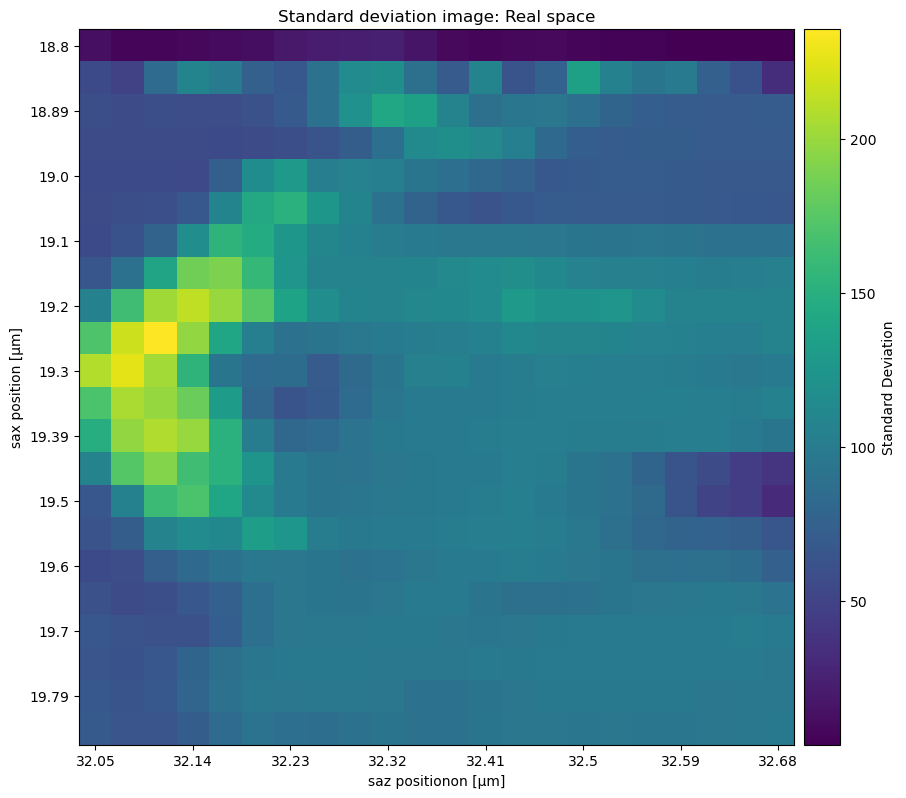

In [39]:
std_image = flattened_arpes.std(-1)
fig, ax = plt.subplots(figsize=(9, 9))
im = ax.imshow(std_image.T)

ax.set_xticks(xticks)
ax.set_xticklabels(steps_dimz[::3])

ax.set_yticks(yticks)
ax.set_yticklabels(steps_dimx[::2])


plt.xlabel('saz positionon [μm]')
plt.ylabel('sax position [μm]')

ax.set_title('Standard deviation image: Real space')

# Create a divider for the axis to align the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# Add colorbar to the aligned axis
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_ylabel('Standard Deviation')

plt.tight_layout(pad=0.5)
plt.savefig(os.path.join(output_directory,'std_deviation_real_space.png'),dpi=600, bbox_inches='tight')
plt.show()


We define 2 special interest regions from the data so we can analyze later the result of the clustering

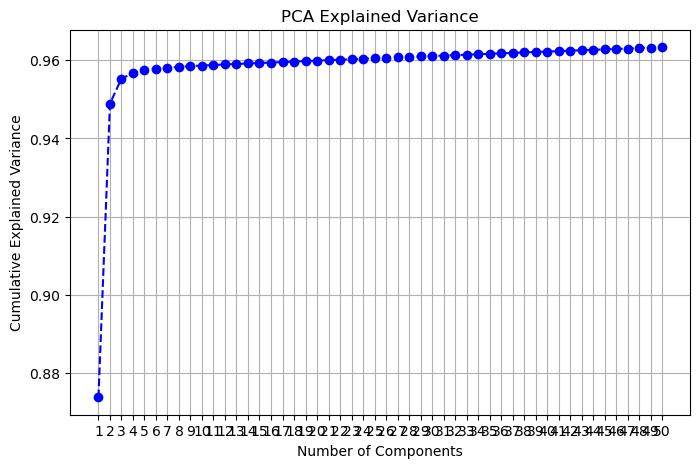

(484, 50)

In [40]:
pca = decomposition.PCA(n_components=50)
X_pca = pca.fit_transform(flattened_all)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_),
         marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))  # Ensure integer x-axis ticks
plt.grid(True)

# Save the figure
plt.savefig(os.path.join(output_directory,'pca_variance.png'))
plt.show()

X_pca.shape

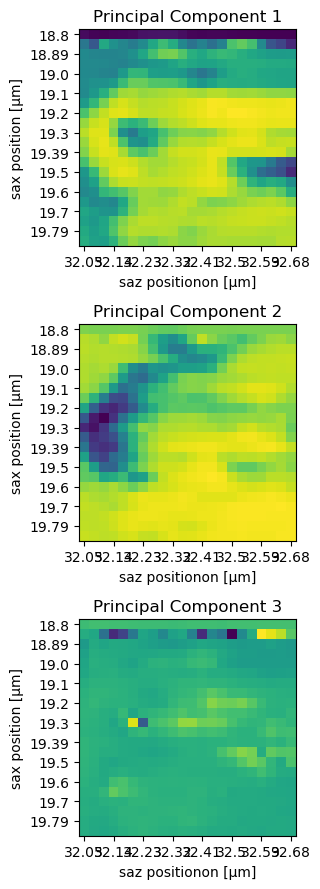

In [41]:
# Number of components to visualize
n = 3  # Change this to the number of components you want to visualize

# Define subplot layout
n_cols = 3
n_rows = (n + n_cols - 1) // n_cols  # Calculate rows needed for n components

# Create figure

fig, axes = plt.subplots(3, 1, figsize=(9, 9 * n_rows))
axes = axes.flatten()

for i in range(n):
    # Reshape each component to 21x12
    component_image = X_pca[:, i].reshape(realdimz,realdimx).T
    
    # Plot the component
    im = axes[i].imshow(component_image, cmap='viridis')
    axes[i].set_title(f'Principal Component {i + 1}')

    axes[i].set_xticks(xticks)
    axes[i].set_xticklabels(steps_dimz[::3])

    axes[i].set_yticks(yticks)
    axes[i].set_yticklabels(steps_dimx[::2])


    axes[i].set_xlabel('saz positionon [μm]')
    axes[i].set_ylabel('sax position [μm]')

    # # Add a colorbar
    # fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

# Hide any unused subplots
for i in range(n, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [42]:
clustering = SpectralClustering(n_clusters=n_clusters,affinity='nearest_neighbors',assign_labels='cluster_qr')
labels_row = clustering.fit_predict(X_pca[:, :3])
sorted_labels = np.argsort([X_pca[labels_row == l].mean(axis=0)[0] for l in np.unique(labels_row)])
label_mapping = {old: new for new, old in enumerate(np.unique(labels_row)[sorted_labels])}
labels = np.vectorize(label_mapping.get)(labels_row)


labels_image = labels.reshape(realdimz, realdimx)

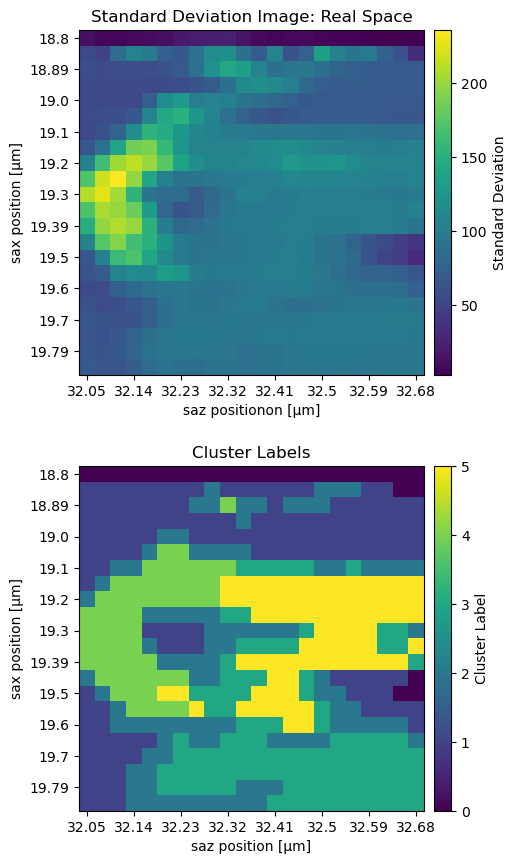

In [43]:
# Standard deviation image
std_image = flattened_arpes.std(-1)
fig, axes = plt.subplots(2, 1, figsize=(9, 9))  # Two rows, one column

# Plot the standard deviation image
ax1 = axes[0]
im1 = ax1.imshow(std_image.T, cmap='viridis')  # You can customize the colormap
ax1.set_title('Standard Deviation Image: Real Space')

ax1.set_xticks(xticks)
ax1.set_xticklabels(steps_dimz[::3])

ax1.set_yticks(yticks)
ax1.set_yticklabels(steps_dimx[::2])

ax1.set_xlabel('saz positionon [μm]')
ax1.set_ylabel('sax position [μm]')

# Create a divider for the axis to align the colorbar
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.1)

# Add colorbar to the aligned axis
cbar1 = fig.colorbar(im1, cax=cax1)
cbar1.ax.set_ylabel('Standard Deviation')

# Plot the labels image
ax2 = axes[1]
im2 = ax2.imshow(labels_image.T)  # Customize colormap for categorical data
ax2.set_title('Cluster Labels')


ax2.set_xticks(xticks)
ax2.set_xticklabels(steps_dimz[::3])


ax2.set_yticks(yticks)
ax2.set_yticklabels(steps_dimx[::2])



ax2.set_xlabel('saz position [μm]')
ax2.set_ylabel('sax position [μm]')
# Create a divider for the axis to align the colorbar
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)

# Add colorbar to the aligned axis
cbar2 = fig.colorbar(im2, cax=cax2)
cbar2.ax.set_ylabel('Cluster Label')

# Adjust layout
plt.tight_layout(pad=2.0)
plt.savefig(os.path.join(output_directory,'combined_std_and_labels_with_colorbars.png'), dpi=600, bbox_inches='tight')
plt.show()


In [44]:
# Create a 3D scatter plot with color based on cluster labels
fig = go.Figure(data=[go.Scatter3d(
    x=X_pca[:, 0], 
    y=X_pca[:, 1], 
    z=X_pca[:, 2], 
    mode='markers',
    marker=dict(
        size=5,
        color=labels,  # Color based on cluster labels
        colorscale='Viridis',  # Choose a colorscale
        opacity=0.8,
        colorbar=dict(title="Cluster Label")  # Add colorbar title
    )
)])

# Add axis labels
fig.update_layout(
    scene=dict(
        xaxis_title='Principal Component 1',
        yaxis_title='Principal Component 2',
        zaxis_title='Principal Component 3'
    ),
    title='3D PCA Scatter Plot',
    margin=dict(l=0, r=0, b=0, t=40)  # Adjust margins for better layout
)

# Plot the figure in a separate window
plot(fig, auto_open=True, filename=os.path.join(output_directory,'3d_scatter_plot.html'))

'/home/mraventos/acode/Marcraven/InCAEM/LOREA/output_011_Au_Mica/3d_scatter_plot.html'

kf.service.services: KApplicationTrader: mimeType "x-scheme-handler/file" not found
ATTENTION: default value of option mesa_glthread overridden by environment.
ATTENTION: default value of option mesa_glthread overridden by environment.
ATTENTION: default value of option mesa_glthread overridden by environment.


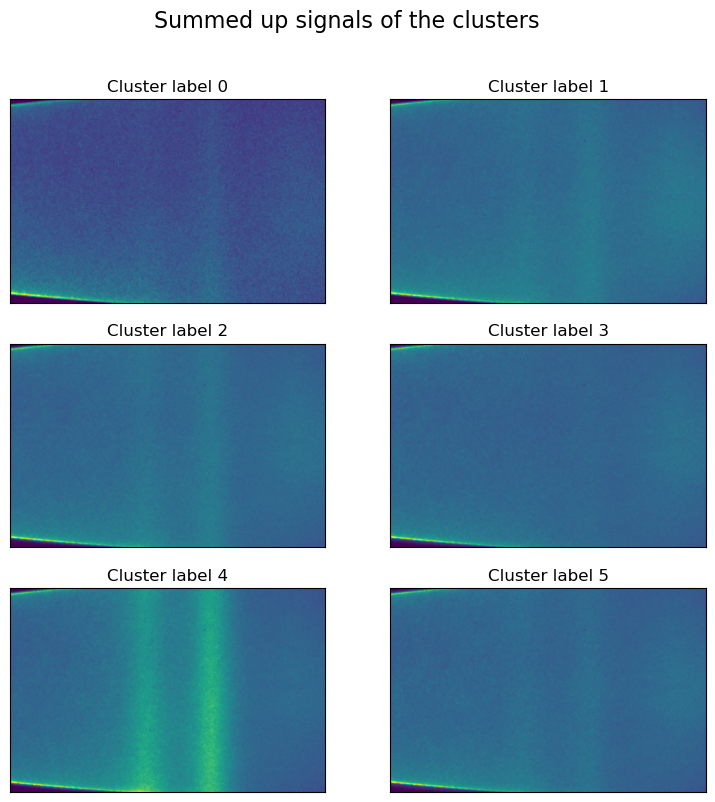

In [45]:
# Determine the number of rows needed for two columns
n_rows = int(np.ceil(n_clusters / 2))

plt.figure(figsize=(9, 3*n_rows))
plt.suptitle('Summed up signals of the clusters',size=16)

for i in range(n_clusters):
    plt.subplot(n_rows, 2, i + 1)
    image_to_plot = data[labels_image == i, :, :].sum(axis=0)
    plt.imshow(image_to_plot, vmax=image_to_plot.max() * contrast)
    plt.title(f'Cluster label {i}')
    
    # Remove x and y ticks
    plt.xticks([])
    plt.yticks([])

# Adjust layout after all plots are created
# plt.tight_layout(rect=[0, 0.01, 1, 0.95])  # Adjust layout while keeping the title space

# Save figure
plt.savefig(os.path.join(output_directory, 'cluster_label_signals.png'), dpi=600, bbox_inches='tight')

plt.show()